# Non-Maximum Supression Validation


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark(cores=4)
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 19:29:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/26 19:29:57 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/04/26 19:29:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Sat Apr 26 07:30:00 PM EDT 2025


### NMS detections

In [5]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data"
test_path = f"{data_path}/detection/test_2024_subset20/test_2024_subset20_detection_v1"
detection_df = spark.read.parquet(test_path)
detection_df.printSchema()
detection_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- extracted_bbox: array (nullable = true)
 |    |    |-- element: binary (containsNull = true)
 |    |-- boxes: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: integer (containsNull = true)
 |    |-- scores: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- text_labels: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- sample_id: integer (nullable = true)



+--------------------+--------------------+---------+
|          image_name|              output|sample_id|
+--------------------+--------------------+---------+
|CBN-PdlC-C1-20200...|{[[89 50 4E 47 0D...|        0|
|CBN-PdlC-B6-20150...|{[[89 50 4E 47 0D...|        0|
|CBN-Pla-B2-201407...|{[[89 50 4E 47 0D...|        0|
|CBN-Pla-D5-201607...|{[[89 50 4E 47 0D...|        0|
|CBN-PdlC-A1-20180...|{[[89 50 4E 47 0D...|        0|
+--------------------+--------------------+---------+
only showing top 5 rows



In [6]:
detection_df.count()

20

In [7]:
# Path and dataset names
test_path = f"{data_path}/parquet/test_2024"
test_df = spark.read.parquet(test_path)
test_df.printSchema()
test_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)



+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-PdlC-C6-20130...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-Pla-D3-201508...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C3-20190...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C1-20200...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B2-20160...|/test_2024/images...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [11]:
# join with test_df
joined_df = detection_df.join(test_df, on="image_name", how="inner")
joined_df.printSchema()
# get first imane name
image_name = joined_df.select("image_name").first()[0]
image_row = joined_df.filter(joined_df.image_name == image_name).collect()

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- extracted_bbox: array (nullable = true)
 |    |    |-- element: binary (containsNull = true)
 |    |-- boxes: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: integer (containsNull = true)
 |    |-- scores: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- text_labels: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- sample_id: integer (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)



In [9]:
display(image_name)

'CBN-PdlC-B6-20150810.jpg'

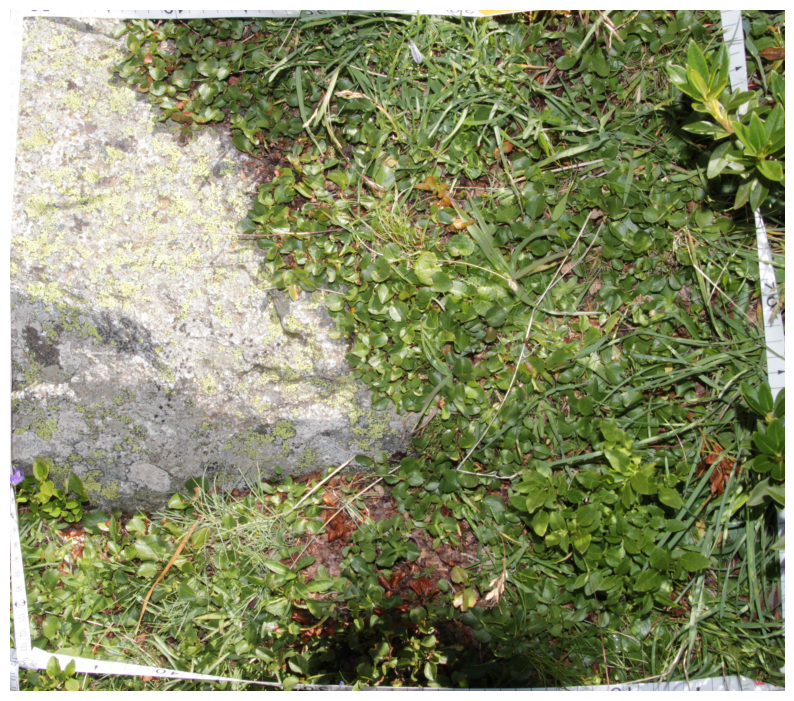

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from plantclef.serde import deserialize_image


# extract image
img_bytes = image_row[0]["data"]
np_arr = np.frombuffer(img_bytes, np.uint8)
img = deserialize_image(img_bytes)  # Pillow image

# plot Pillow image
plt.figure(figsize=(10, 10))
plt.imshow(img)  # img_rgb
plt.axis("off")
plt.show()

In [20]:
import matplotlib.patches as patches


def plot_detections(image, detections):
    # assign colors to labels
    unique_labels = list(set(detections["text_labels"]))
    cmap = plt.get_cmap("tab10", len(unique_labels))
    label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)  # Pillow image

    # Loop through detections and draw boxes with corresponding label colors
    for box, label, score in zip(
        detections["boxes"], detections["text_labels"], detections["scores"]
    ):
        x_min, y_min, x_max, y_max = box
        color = label_to_color[label]

        # Create a rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)

        # Add label text
        ax.text(
            x_min,
            y_min - 5,
            f"{label} {score:.2f}",
            fontsize=12,
            color="white",
            bbox=dict(facecolor=color, edgecolor="none", pad=2.0),
        )

    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [21]:
detections = {
    "boxes": image_row[0]["output"]["boxes"],
    "text_labels": image_row[0]["output"]["text_labels"],
    "scores": image_row[0]["output"]["scores"],
}

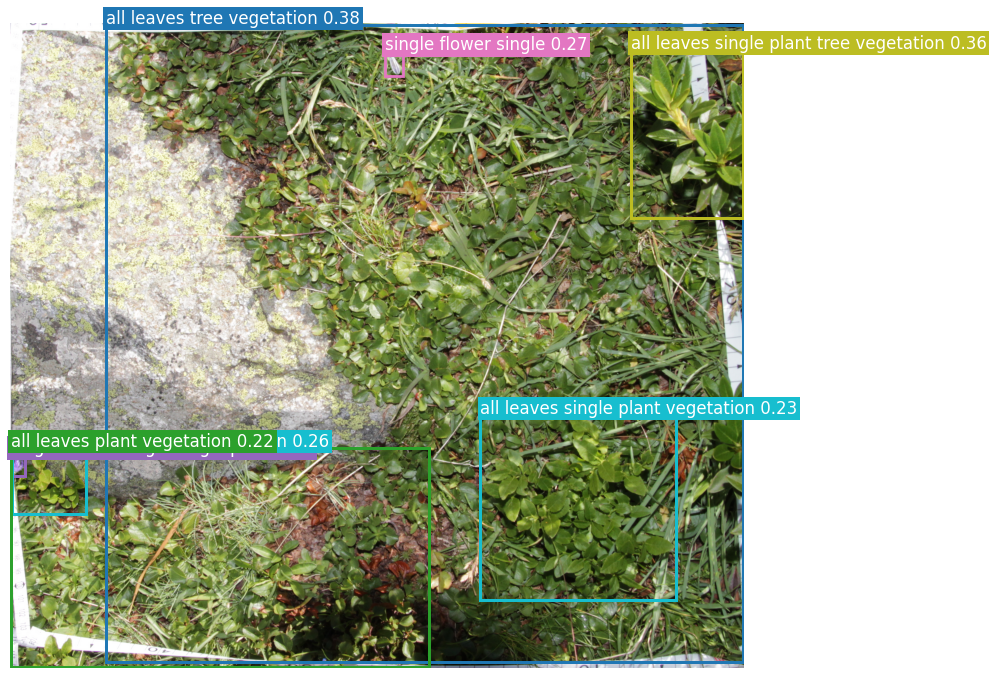

In [22]:
plot_detections(image=img, detections=detections)

In [23]:
len(detections["boxes"]), len(detections["text_labels"]), len(detections["scores"])

(17, 17, 17)

In [24]:
detections["text_labels"]

['all leaves tree vegetation',
 'all leaves tree vegetation',
 'single flower single single plant',
 'single flower single single plant',
 'all leaves single plant tree vegetation',
 'all leaves single plant tree vegetation',
 'all leaves single plant tree vegetation',
 'single flower single',
 'all leaves single plant vegetation',
 'all leaves single plant vegetation',
 'all leaves single plant vegetation',
 'all leaves single plant vegetation',
 'all leaves single plant vegetation',
 'all leaves single plant vegetation',
 'all leaves plant vegetation',
 'all leaves plant vegetation',
 'all leaves plant vegetation']

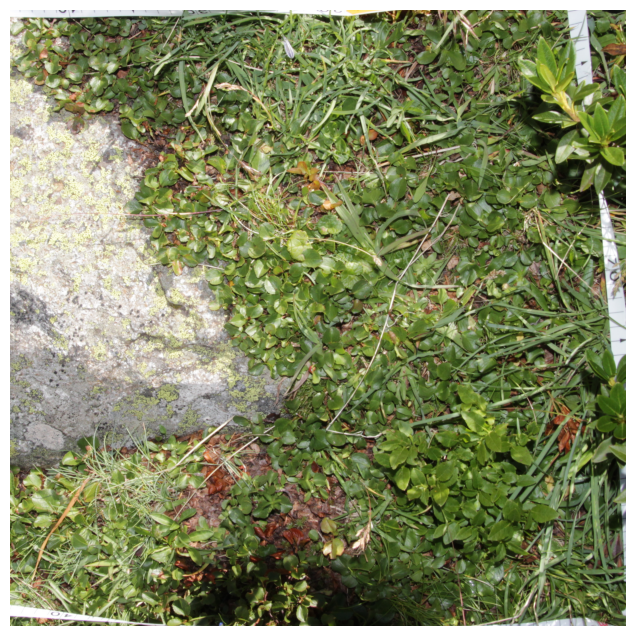

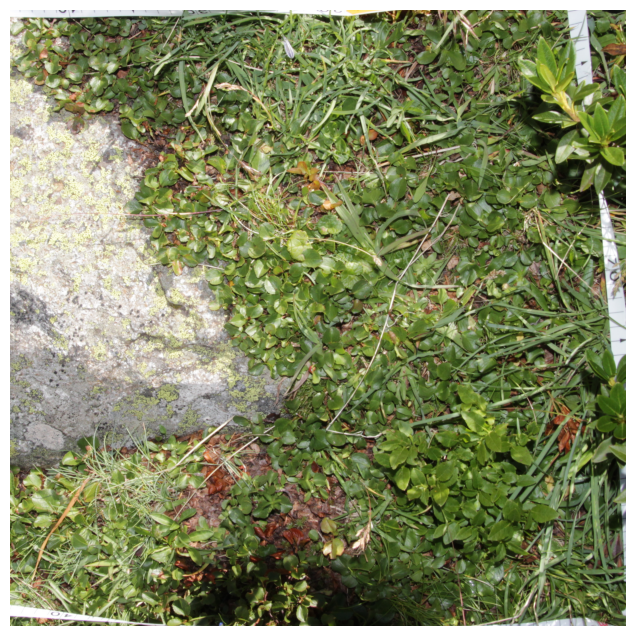

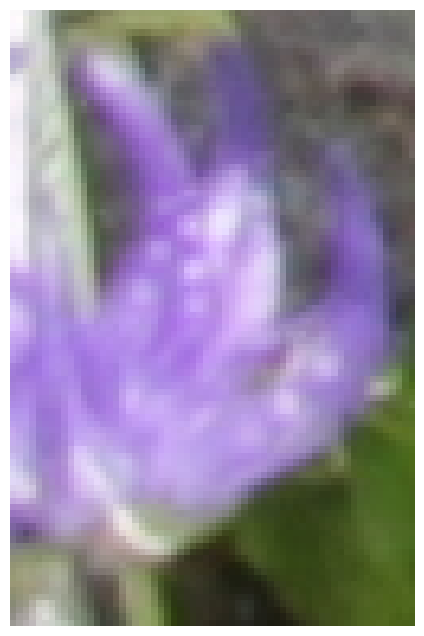

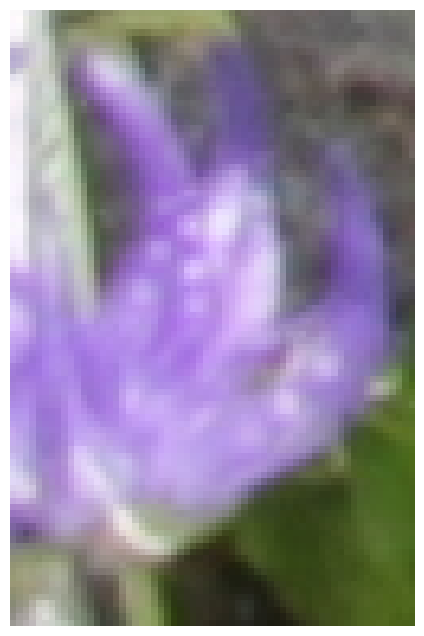

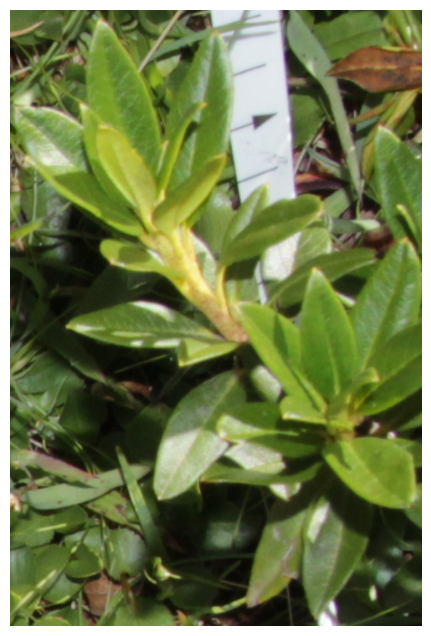

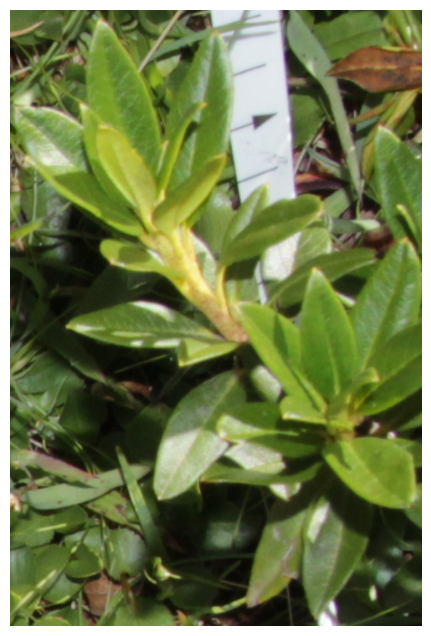

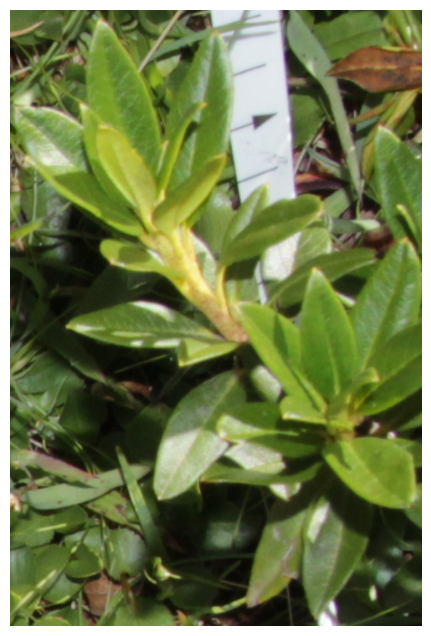

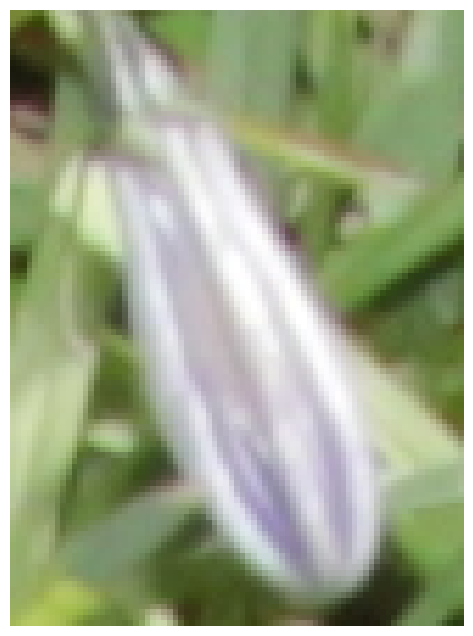

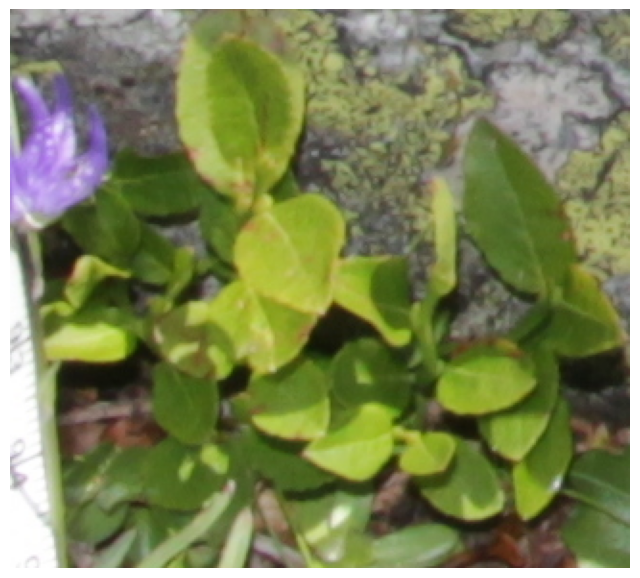

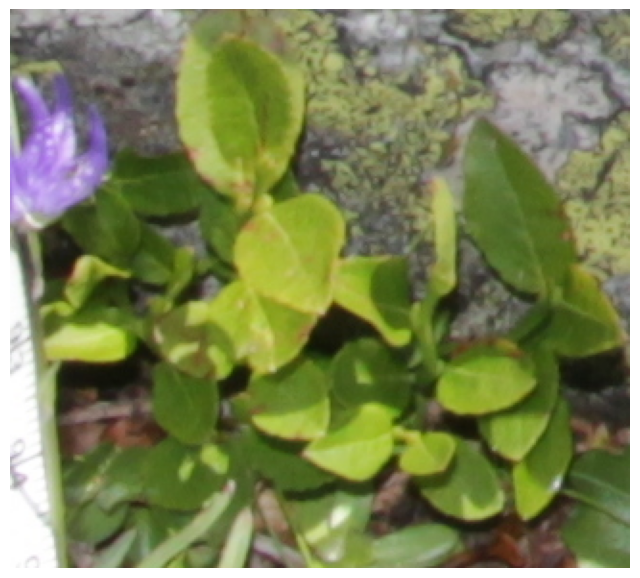

In [34]:
from plantclef.serde import deserialize_image

bboxes = image_row[0]["output"]["extracted_bbox"]
for i in range(10):
    bbox = bboxes[i]
    img_bbox = deserialize_image(bbox)
    # plot Pillow image
    plt.figure(figsize=(8, 8))
    plt.imshow(img_bbox)  # img_rgb
    plt.axis("off")
    plt.show()